# Mental Health in Tech Survey - Unsupervised Learning Pipeline

**Dataset:** OSMI 2016 Mental Health in Tech Survey — 1,433 respondents x 63 survey questions.

**Goal:** Segment tech workers based on mental health attitudes, workplace environment, and personal history using unsupervised learning.

### Pipeline Stages
1. Data loading & exploratory analysis
2. Cleaning & preprocessing
3. Feature engineering
4. Dimensionality reduction (PCA)
5. Clustering (K-Means, Agglomerative, DBSCAN)
6. Visualization & interpretation

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", font_scale=1.05)
%matplotlib inline

DATA_PATH = "archive/mental-heath-in-tech-2016_20161114.csv"
OUT = "outputs"
os.makedirs(OUT, exist_ok=True)

## 1. Data Loading & Exploration

The raw CSV has 63 columns with very long question-text headers. We rename them to short aliases for readability.

In [2]:
SHORT_NAMES = {
    "Are you self-employed?": "self_employed",
    "How many employees does your company or organization have?": "company_size",
    "Is your employer primarily a tech company/organization?": "tech_company",
    "Is your primary role within your company related to tech/IT?": "tech_role",
    "Does your employer provide mental health benefits as part of healthcare coverage?": "mh_benefits",
    "Do you know the options for mental health care available under your employer-provided coverage?": "know_mh_options",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?": "employer_discussed_mh",
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?": "employer_mh_resources",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?": "anonymity_protected",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:": "leave_ease",
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?": "discuss_mh_employer_neg",
    "Do you think that discussing a physical health issue with your employer would have negative consequences?": "discuss_ph_employer_neg",
    "Would you feel comfortable discussing a mental health disorder with your coworkers?": "comfort_mh_coworkers",
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?": "comfort_mh_supervisor",
    "Do you feel that your employer takes mental health as seriously as physical health?": "employer_mh_serious",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?": "observed_neg_consequences",
    "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?": "medical_coverage_mh",
    "Do you know local or online resources to seek help for a mental health disorder?": "know_resources",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?": "reveal_clients",
    "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?": "reveal_clients_neg",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?": "reveal_coworkers",
    "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?": "reveal_coworkers_neg",
    "Do you believe your productivity is ever affected by a mental health issue?": "productivity_affected",
    "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?": "pct_time_affected",
    "Do you have previous employers?": "has_prev_employers",
    "Have your previous employers provided mental health benefits?": "prev_mh_benefits",
    "Were you aware of the options for mental health care provided by your previous employers?": "prev_aware_options",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?": "prev_discussed_mh",
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?": "prev_mh_resources",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?": "prev_anonymity",
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?": "prev_discuss_mh_neg",
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?": "prev_discuss_ph_neg",
    "Would you have been willing to discuss a mental health issue with your previous co-workers?": "prev_comfort_coworkers",
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?": "prev_comfort_supervisor",
    "Did you feel that your previous employers took mental health as seriously as physical health?": "prev_mh_serious",
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?": "prev_observed_neg",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?": "interview_ph",
    "Why or why not?": "interview_ph_why",
    "Would you bring up a mental health issue with a potential employer in an interview?": "interview_mh",
    "Do you feel that being identified as a person with a mental health issue would hurt your career?": "mh_hurts_career",
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?": "coworkers_view_neg",
    "How willing would you be to share with friends and family that you have a mental illness?": "share_family",
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?": "unsupportive_response",
    "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?": "others_discourage_reveal",
    "Do you have a family history of mental illness?": "family_history",
    "Have you had a mental health disorder in the past?": "past_mh_disorder",
    "Do you currently have a mental health disorder?": "current_mh_disorder",
    "If yes, what condition(s) have you been diagnosed with?": "diagnosed_conditions",
    "If maybe, what condition(s) do you believe you have?": "believed_conditions",
    "Have you been diagnosed with a mental health condition by a medical professional?": "professionally_diagnosed",
    "If so, what condition(s) were you diagnosed with?": "professional_dx_conditions",
    "Have you ever sought treatment for a mental health issue from a mental health professional?": "sought_treatment",
    "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?": "interferes_treated",
    "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?": "interferes_untreated",
    "What is your age?": "age",
    "What is your gender?": "gender",
    "What country do you live in?": "country_live",
    "What US state or territory do you live in?": "state_live",
    "What country do you work in?": "country_work",
    "What US state or territory do you work in?": "state_work",
    "Which of the following best describes your work position?": "work_position",
    "Do you work remotely?": "remote_work",
}

In [3]:
df_raw = pd.read_csv(DATA_PATH)

# Build rename map
rename_map = {orig: short for orig, short in SHORT_NAMES.items() if orig in df_raw.columns}

# Handle duplicate "Why or why not?" columns
why_cols = [c for c in df_raw.columns if c.startswith("Why or why not?")]
if len(why_cols) >= 1:
    rename_map[why_cols[0]] = "interview_ph_why"
if len(why_cols) >= 2:
    rename_map[why_cols[1]] = "interview_mh_why"

df_raw.rename(columns=rename_map, inplace=True)
print(f"Loaded: {df_raw.shape[0]} rows x {df_raw.shape[1]} columns")
df_raw.head(3)

Loaded: 1433 rows x 63 columns


,self_employed,company_size,tech_company,tech_role,mh_benefits,know_mh_options,employer_discussed_mh,employer_mh_resources,anonymity_protected,leave_ease,...,interferes_treated,interferes_untreated,age,gender,country_live,state_live,country_work,state_work,work_position,remote_work
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always


### 1.1 Data Types & Missing Values

In [4]:
print("Data types:")
print(df_raw.dtypes.value_counts())
print(f"\nTotal missing values: {df_raw.isnull().sum().sum():,}")
print(f"Columns with >50% missing: {(df_raw.isnull().mean() > 0.5).sum()}")

Data types:
str        56
int64       4
float64     3
Name: count, dtype: int64

Total missing values: 21,960
Columns with >50% missing: 13


In [ ]:
# Missing values for top 15 columns
missing = df_raw.isnull().sum().sort_values(ascending=False)
missing[missing > 0].head(15)

reveal_clients_neg            1289
pct_time_affected             1229
tech_role                     1170
know_resources                1146
medical_coverage_mh           1146
productivity_affected         1146
reveal_coworkers_neg          1146
reveal_coworkers              1146
reveal_clients                1146
believed_conditions           1111
diagnosed_conditions           865
others_discourage_reveal       776
professional_dx_conditions     722
state_live                     593
state_work                     582
dtype: int64

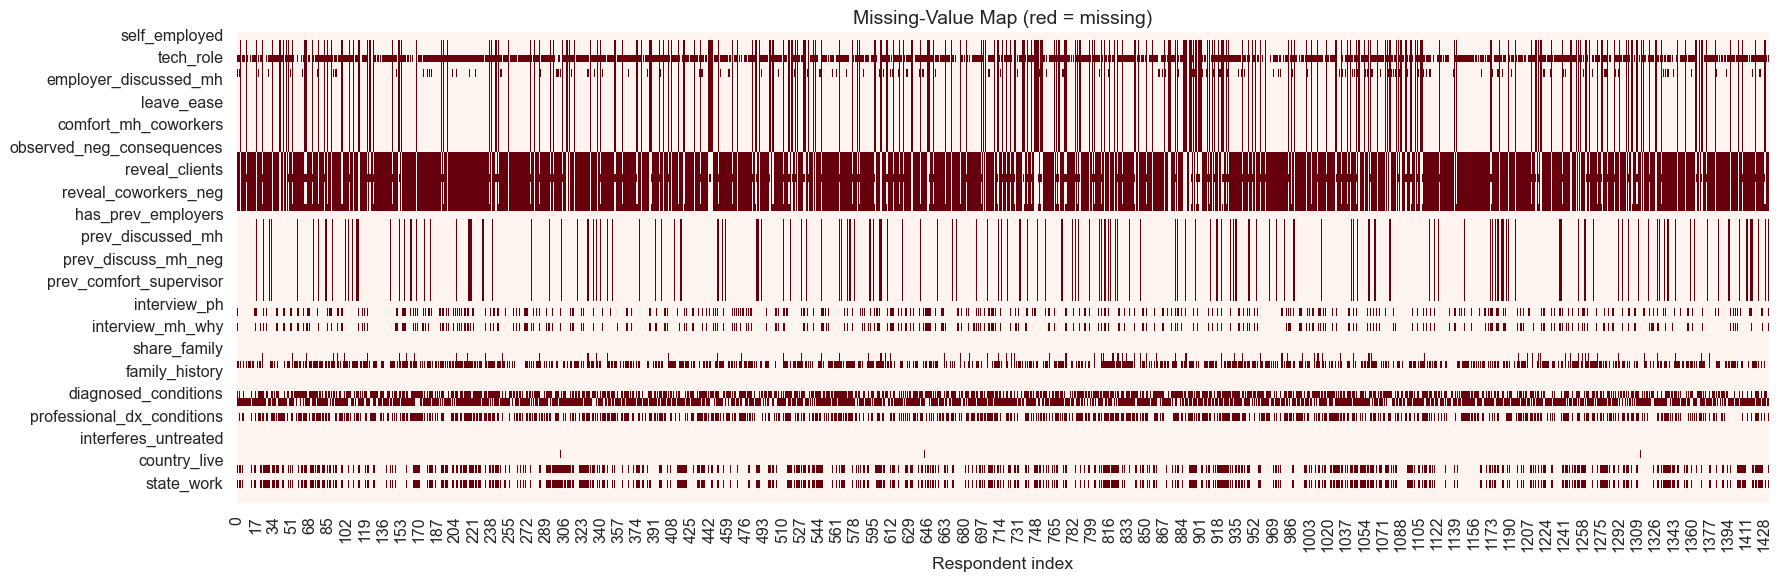

In [6]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(df_raw.isnull().T, cbar=False, cmap="Reds", ax=ax)
ax.set_title("Missing-Value Map (red = missing)", fontsize=14)
ax.set_xlabel("Respondent index")
plt.tight_layout()
fig.savefig(f"{OUT}/01_missing_map.png", dpi=150)
plt.show()

The missingness has a clear block structure: columns like `reveal_clients`, `know_resources`, and `productivity_affected` are only answered by non-self-employed respondents (~80% of data). The diagnosis free-text fields are sparse because they only apply to people who answered "Yes" or "Maybe" to having a disorder.

### 1.2 Demographic Distributions

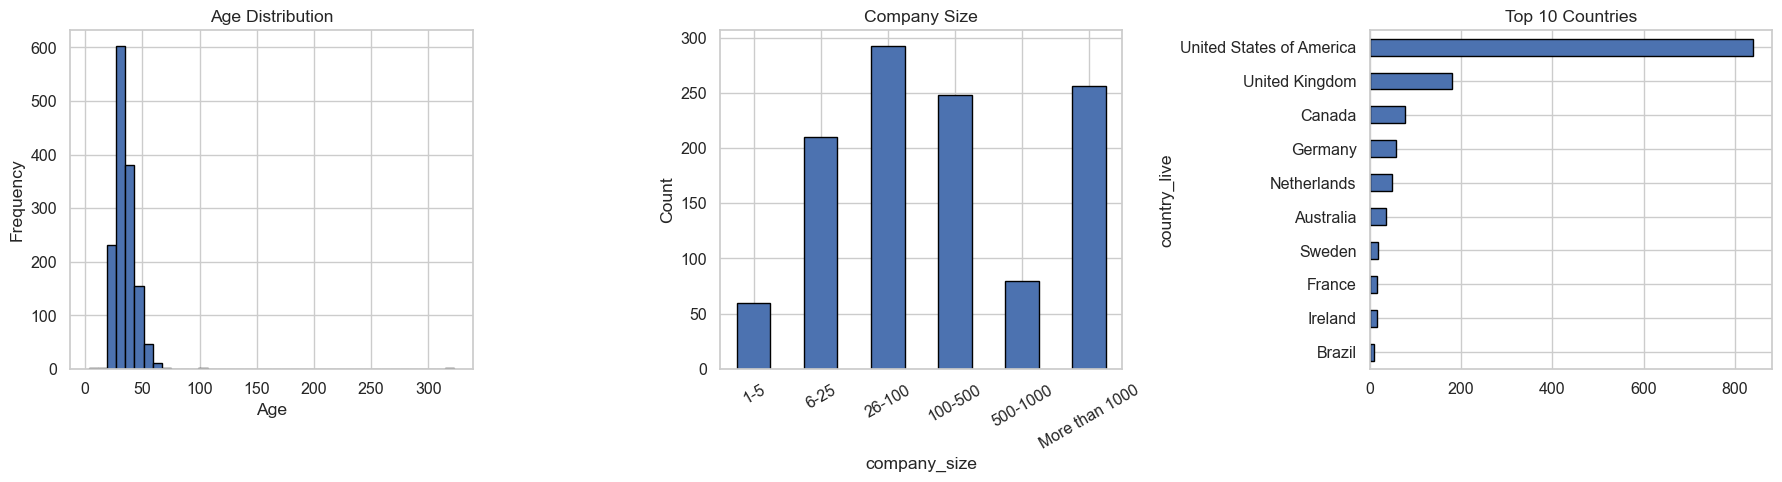

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age
df_raw["age"].dropna().plot.hist(bins=40, edgecolor="black", ax=axes[0])
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")

# Company size
size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
df_raw["company_size"].value_counts().reindex(size_order).dropna().plot.bar(
    ax=axes[1], edgecolor="black")
axes[1].set_title("Company Size")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=30)

# Top countries
df_raw["country_live"].value_counts().head(10).plot.barh(ax=axes[2], edgecolor="black")
axes[2].set_title("Top 10 Countries")
axes[2].invert_yaxis()

plt.tight_layout()
fig.savefig(f"{OUT}/02_demographics.png", dpi=150)
plt.show()

In [8]:
df_raw.describe()

,self_employed,tech_company,tech_role,medical_coverage_mh,has_prev_employers,sought_treatment,age
count,1433.000000,1146.000000,263.000000,287.000000,1433.000000,1433.000000,1433.000000
mean,0.200279,0.770506,0.942966,0.644599,0.882066,0.585485,34.286113
std,0.400349,0.420691,0.232350,0.479471,0.322643,0.492810,11.290931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,28.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,39.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,323.000000


Notable: age has a max of 323 and a min of 3 — clear outliers to clean. The majority of respondents are from the US/UK, male, and work at tech companies.

---
## 2. Data Cleaning

Key cleaning steps:
- **Gender:** Free-text field with dozens of spellings → normalise to Male / Female / Non-binary
- **Age:** Clip implausible values (< 15 or > 80) to NaN
- **Drop:** Free-text "why" columns, redundant US-state columns

In [ ]:
df = df_raw.copy()

# Gender normalisation
def clean_gender(s):
    s = s.fillna("unknown").astype(str).str.strip().str.lower()
    male_kw = ["male", "m", "man", "cis male", "cis man", "mail", "maile",
               "mal", "male (cis)", "msle", "malr"]
    female_kw = ["female", "f", "woman", "cis female", "cis-woman", "femail",
                 "femake", "cis-female/femme"]
    def _map(val):
        if not isinstance(val, str):
            return "Non-binary"
        if val in male_kw or val.startswith("male"):
            return "Male"
        if val in female_kw or val.startswith("female"):
            return "Female"
        return "Non-binary"
    return s.map(_map)

df["gender"] = clean_gender(df["gender"])
print("Gender distribution after cleaning:")
print(df["gender"].value_counts())

Gender distribution after cleaning:
gender
Male          1055
Female         336
Non-binary      42
Name: count, dtype: int64


In [ ]:
# Age - clip outliers
df["age"] = pd.to_numeric(df["age"], errors="coerce")
print(f"Age outliers removed: {((df['age'] < 15) | (df['age'] > 80)).sum()}")
df.loc[df["age"] < 15, "age"] = np.nan
df.loc[df["age"] > 80, "age"] = np.nan

# Drop free-text & redundant geo columns
drop_cols = ["interview_ph_why", "interview_mh_why",
             "state_live", "country_work", "state_work"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# Replace empty strings / whitespace with NaN
df.replace(r"^\s*$", np.nan, regex=True, inplace=True)

print(f"\nAfter cleaning: {df.shape[0]} rows x {df.shape[1]} columns")

Age outliers removed: 3

After cleaning: 1433 rows x 58 columns


In [11]:
# Save a clean copy for cluster profiling later (before encoding)
df_for_profiling = df.copy()

---
## 3. Feature Engineering

Transform the cleaned survey responses into ML-ready features:
- Parse pipe-separated multi-select fields (diagnosis, work position) into binary flags
- Ordinal-encode ordered scales (company size, leave ease, interference)
- Collapse high-cardinality country to top-5 + "Other"
- One-hot encode remaining low-cardinality categoricals

In [ ]:
# Parse diagnosis multi-select fields into binary flags
condition_labels = [
    "Anxiety Disorder", "Mood Disorder", "Substance Use Disorder",
    "Attention Deficit", "Personality Disorder", "Obsessive-Compulsive",
    "Post-traumatic Stress", "Eating Disorder", "Psychotic Disorder",
]
for col in ["diagnosed_conditions", "believed_conditions", "professional_dx_conditions"]:
    if col not in df.columns:
        continue
    raw = df[col].fillna("")
    for label in condition_labels:
        flag_name = f"{col[:4]}_{label.split()[0].lower()}"
        df[flag_name] = raw.str.contains(label, case=False, na=False).astype(int)

df.drop(columns=[c for c in ["diagnosed_conditions", "believed_conditions",
                              "professional_dx_conditions"] if c in df.columns], inplace=True)

# Quick check: how common are the conditions?
diag_cols = [c for c in df.columns if c.startswith(("diag_", "beli_", "prof_"))]
df[diag_cols].sum().sort_values(ascending=False).head(10)

prof_mood              526
diag_mood              412
prof_anxiety           373
diag_anxiety           345
beli_mood              219
beli_anxiety           192
prof_attention         136
diag_attention         121
prof_post-traumatic     70
diag_post-traumatic     69
dtype: int64

In [ ]:
# Parse work_position multi-select
if "work_position" in df.columns:
    position_labels = ["Back-end", "Front-end", "Supervisor", "Executive",
                       "DevOps", "Support", "Designer", "One-person"]
    raw = df["work_position"].fillna("")
    for label in position_labels:
        df[f"role_{label.lower().replace('-', '_')}"] = (
            raw.str.contains(label, case=False, na=False).astype(int))
    df.drop(columns=["work_position"], inplace=True)

In [ ]:
# Ordinal encoding for ordered scales
size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
if "company_size" in df.columns:
    df["company_size_ord"] = df["company_size"].map({v: i for i, v in enumerate(size_order)})
    df.drop(columns=["company_size"], inplace=True)

pct_order = ["1-25%", "26-50%", "51-75%", "76-100%"]
if "pct_time_affected" in df.columns:
    df["pct_affected_ord"] = df["pct_time_affected"].map({v: i for i, v in enumerate(pct_order)})
    df.drop(columns=["pct_time_affected"], inplace=True)

leave_order = ["Very difficult", "Somewhat difficult", "Neither easy nor difficult",
               "Somewhat easy", "Very easy", "I don't know"]
if "leave_ease" in df.columns:
    df["leave_ease_ord"] = df["leave_ease"].map({v: i for i, v in enumerate(leave_order)})
    df.drop(columns=["leave_ease"], inplace=True)

share_order = ["Not open at all", "Not applicable to me (I do not have a mental illness)",
               "Somewhat not open", "Neutral", "Somewhat open", "Very open"]
if "share_family" in df.columns:
    df["share_family_ord"] = df["share_family"].map({v: i for i, v in enumerate(share_order)})
    df.drop(columns=["share_family"], inplace=True)

interf_order = ["Not applicable to me", "Never", "Rarely", "Sometimes", "Often"]
for col in ["interferes_treated", "interferes_untreated"]:
    if col in df.columns:
        df[f"{col}_ord"] = df[col].map({v: i for i, v in enumerate(interf_order)})
        df.drop(columns=[col], inplace=True)

print("Ordinal features created.")

Ordinal features created.


In [ ]:
# Country → region (top 5 + Other)
if "country_live" in df.columns:
    top5 = df["country_live"].value_counts().head(5).index.tolist()
    df["region"] = df["country_live"].apply(lambda x: x if x in top5 else "Other")
    df.drop(columns=["country_live"], inplace=True)
    print("Region distribution:")
    print(df["region"].value_counts())

Region distribution:
region
United States of America    840
Other                       229
United Kingdom              180
Canada                       78
Germany                      58
Netherlands                  48
Name: count, dtype: int64


In [ ]:
# Binary Yes/No → 0/1
for col in df.select_dtypes(include=["object", "string"]).columns:
    unique = df[col].dropna().unique()
    if set(unique).issubset({"Yes", "No", "1", "0"}):
        df[col] = df[col].map({"Yes": 1, "No": 0})

# One-hot encode remaining low-cardinality categoricals
cat_cols = [c for c in df.select_dtypes(include=["object", "string"]).columns
            if df[c].nunique() < 12]
print(f"One-hot encoding {len(cat_cols)} categorical columns...")
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

# Drop any remaining high-cardinality text columns
remaining_obj = df.select_dtypes(include=["object", "string"]).columns.tolist()
if remaining_obj:
    print(f"Dropping high-cardinality columns: {remaining_obj}")
    df.drop(columns=remaining_obj, inplace=True)

print(f"\nFinal feature matrix: {df.shape[0]} rows x {df.shape[1]} columns")
df.head()

One-hot encoding 39 categorical columns...

Final feature matrix: 1433 rows x 150 columns


,self_employed,tech_company,tech_role,observed_neg_consequences,medical_coverage_mh,has_prev_employers,professionally_diagnosed,sought_treatment,age,diag_anxiety,...,current_mh_disorder_Yes,gender_Male,gender_Non-binary,remote_work_Never,remote_work_Sometimes,region_Germany,region_Netherlands,region_Other,region_United Kingdom,region_United States of America
0,0,1.0,NaN,0.0,NaN,1,1,0,39.0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,1.0,NaN,0.0,NaN,1,1,1,29.0,1,...,1,1,0,1,0,0,0,0,0,1
2,0,1.0,NaN,0.0,NaN,1,0,1,38.0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,NaN,NaN,NaN,1.0,1,1,1,43.0,1,...,1,1,0,0,1,0,0,0,1,0
4,0,0.0,1.0,0.0,NaN,1,1,1,43.0,1,...,1,0,0,0,1,0,0,0,0,1


---
## 4. Preprocessing for ML

Impute remaining NaN values with column medians, then standardise all features to zero mean / unit variance.

In [17]:
df_feat = df.copy()

# Median imputation — use assignment (not inplace) for pandas 2.x CoW compatibility
for col in df_feat.columns:
    if df_feat[col].isnull().any():
        df_feat[col] = df_feat[col].fillna(df_feat[col].median())

feature_names = df_feat.columns.tolist()
scaler = StandardScaler()
X = scaler.fit_transform(df_feat.values)

print(f"ML-ready matrix: {X.shape[0]} samples x {X.shape[1]} features")
print(f"Remaining NaNs: {np.isnan(X).sum()}")
assert np.isnan(X).sum() == 0, "ERROR: NaNs remain — check imputation step"

ML-ready matrix: 1433 samples x 150 features
Remaining NaNs: 0


---
## 5. Dimensionality Reduction — PCA

We use PCA to reduce noise and find the components explaining 90% of variance, then inspect the loadings to understand what each axis captures.

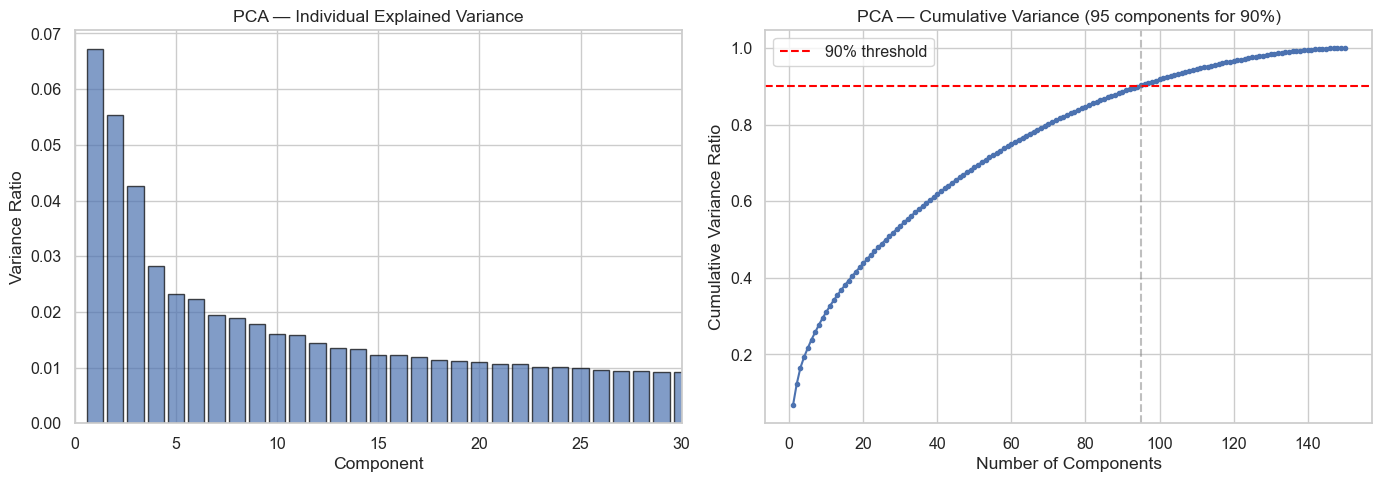

Retaining 95 components (90.3% variance)


In [18]:
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n90 = np.searchsorted(cum_var, 0.90) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, edgecolor="black", alpha=0.7)
axes[0].set_title("PCA — Individual Explained Variance")
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Variance Ratio")
axes[0].set_xlim(0, 30)

axes[1].plot(range(1, len(cum_var) + 1), cum_var, "o-", markersize=3)
axes[1].axhline(0.90, ls="--", color="red", label="90% threshold")
axes[1].axvline(n90, ls="--", color="gray", alpha=0.5)
axes[1].set_title(f"PCA — Cumulative Variance ({n90} components for 90%)")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance Ratio")
axes[1].legend()

plt.tight_layout()
fig.savefig(f"{OUT}/03_pca_scree.png", dpi=150)
plt.show()

X_pca = X_pca_full[:, :n90]
print(f"Retaining {n90} components ({cum_var[n90-1]:.1%} variance)")

In [19]:
# Top loadings for first 3 components
for i in range(3):
    loadings = pd.Series(pca_full.components_[i], index=feature_names)
    top = loadings.abs().nlargest(8).index
    print(f"\nPC{i+1} (var={pca_full.explained_variance_ratio_[i]:.2%}):")
    for feat in top:
        print(f"  {feat:>45s}  {loadings[feat]:+.3f}")


PC1 (var=6.72%):
                       professionally_diagnosed  +0.252
                        current_mh_disorder_Yes  +0.242
                       interferes_untreated_ord  +0.242
                           past_mh_disorder_Yes  +0.241
                               sought_treatment  +0.234
                         interferes_treated_ord  +0.220
                            past_mh_disorder_No  -0.219
                                      prof_mood  +0.217

PC2 (var=5.54%):
                                  self_employed  +0.327
                      productivity_affected_Yes  +0.262
      reveal_coworkers_neg_Not applicable to me  +0.225
                     discuss_ph_employer_neg_No  -0.222
          reveal_coworkers_Not applicable to me  +0.208
                                role_one_person  +0.206
            reveal_clients_Not applicable to me  +0.200
                            medical_coverage_mh  -0.196

PC3 (var=4.26%):
                       comfort_mh_supervisor_No  +

**Interpretation of PCA axes:**
- **PC1 (6.7%):** Mental health diagnosis severity loads on `professionally_diagnosed`, `current_mh_disorder`, `sought_treatment`, mood disorder flags
- **PC2 (5.5%):** Employment structure loads on `self_employed`, productivity questions, and medical coverage
- **PC3 (4.3%):** Workplace stigma perception loads on comfort discussing MH with coworkers/supervisors, perceived career impact

---
## 6. Clustering

### 6.1 Choosing k — Elbow & Silhouette Analysis

Best k by silhouette: 2


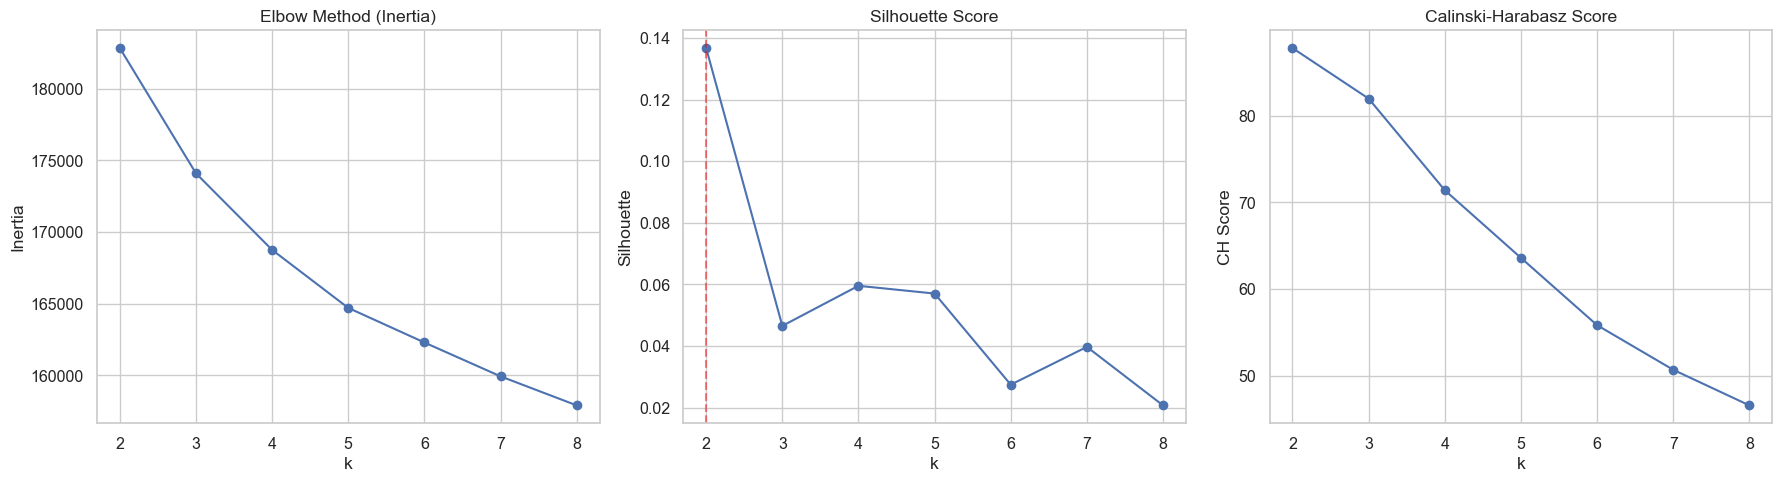

In [20]:
# Elbow method + silhouette scores for k = 2..8
k_range = range(2, 9)
inertias, sil_scores, ch_scores = [], [], []

for k in k_range:
    km_tmp = KMeans(n_clusters=k, n_init=20, random_state=42)
    labs_tmp = km_tmp.fit_predict(X_pca)
    inertias.append(km_tmp.inertia_)
    sil_scores.append(silhouette_score(X_pca, labs_tmp))
    ch_scores.append(calinski_harabasz_score(X_pca, labs_tmp))

best_k_sil = list(k_range)[np.argmax(sil_scores)]
print(f"Best k by silhouette: {best_k_sil}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(list(k_range), inertias, "o-")
axes[0].set_title("Elbow Method (Inertia)")
axes[0].set_xlabel("k"); axes[0].set_ylabel("Inertia")

axes[1].plot(list(k_range), sil_scores, "o-")
axes[1].axvline(best_k_sil, ls="--", color="red", alpha=0.5)
axes[1].set_title("Silhouette Score")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Silhouette")

axes[2].plot(list(k_range), ch_scores, "o-")
axes[2].set_title("Calinski-Harabasz Score")
axes[2].set_xlabel("k"); axes[2].set_ylabel("CH Score")

plt.tight_layout()
fig.savefig(f"{OUT}/05_elbow_silhouette.png", dpi=150)
plt.show()

The silhouette-optimal k=2 trivially separates self-employed from employed respondents (the survey routing creates a structural split). For **actionable** segmentation we use k=3, which reveals meaningful mental-health-related groupings within the employed population.

### 6.2 Fit Clustering Models

In [21]:
PRIMARY_K = max(best_k_sil, 3)
print(f"Primary segmentation: k={PRIMARY_K}")

# K-Means
km = KMeans(n_clusters=PRIMARY_K, n_init=20, random_state=42)
labels_km = km.fit_predict(X_pca)
print(f"K-Means:        silhouette={silhouette_score(X_pca, labels_km):.3f}")

# Agglomerative (Ward)
agg = AgglomerativeClustering(n_clusters=PRIMARY_K)
labels_agg = agg.fit_predict(X_pca)
print(f"Agglomerative:  silhouette={silhouette_score(X_pca, labels_agg):.3f}")

# DBSCAN (auto-tune eps)
nn = NearestNeighbors(n_neighbors=10)
nn.fit(X_pca)
distances, _ = nn.kneighbors(X_pca)
eps_candidate = np.percentile(np.sort(distances[:, -1]), 90)

db = DBSCAN(eps=eps_candidate, min_samples=10)
labels_db = db.fit_predict(X_pca)
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = (labels_db == -1).sum()
print(f"DBSCAN:         {n_clusters_db} cluster(s), {n_noise} noise points")

Primary segmentation: k=3
K-Means:        silhouette=0.047
Agglomerative:  silhouette=0.050
DBSCAN:         1 cluster(s), 62 noise points


---
## 7. Visualization

### 7.1 Cluster Assignments on PCA

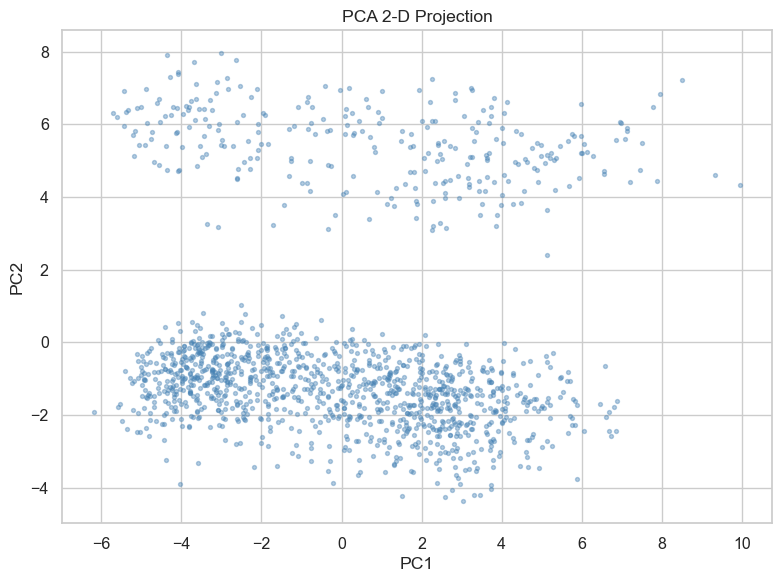

In [22]:
# PCA 2-D projection
pca2d = PCA(n_components=2, random_state=42).fit_transform(X)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pca2d[:, 0], pca2d[:, 1], s=8, alpha=0.4, c="steelblue")
ax.set_title("PCA 2-D Projection")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

plt.tight_layout()
fig.savefig(f"{OUT}/04_pca_2d.png", dpi=150)
plt.show()

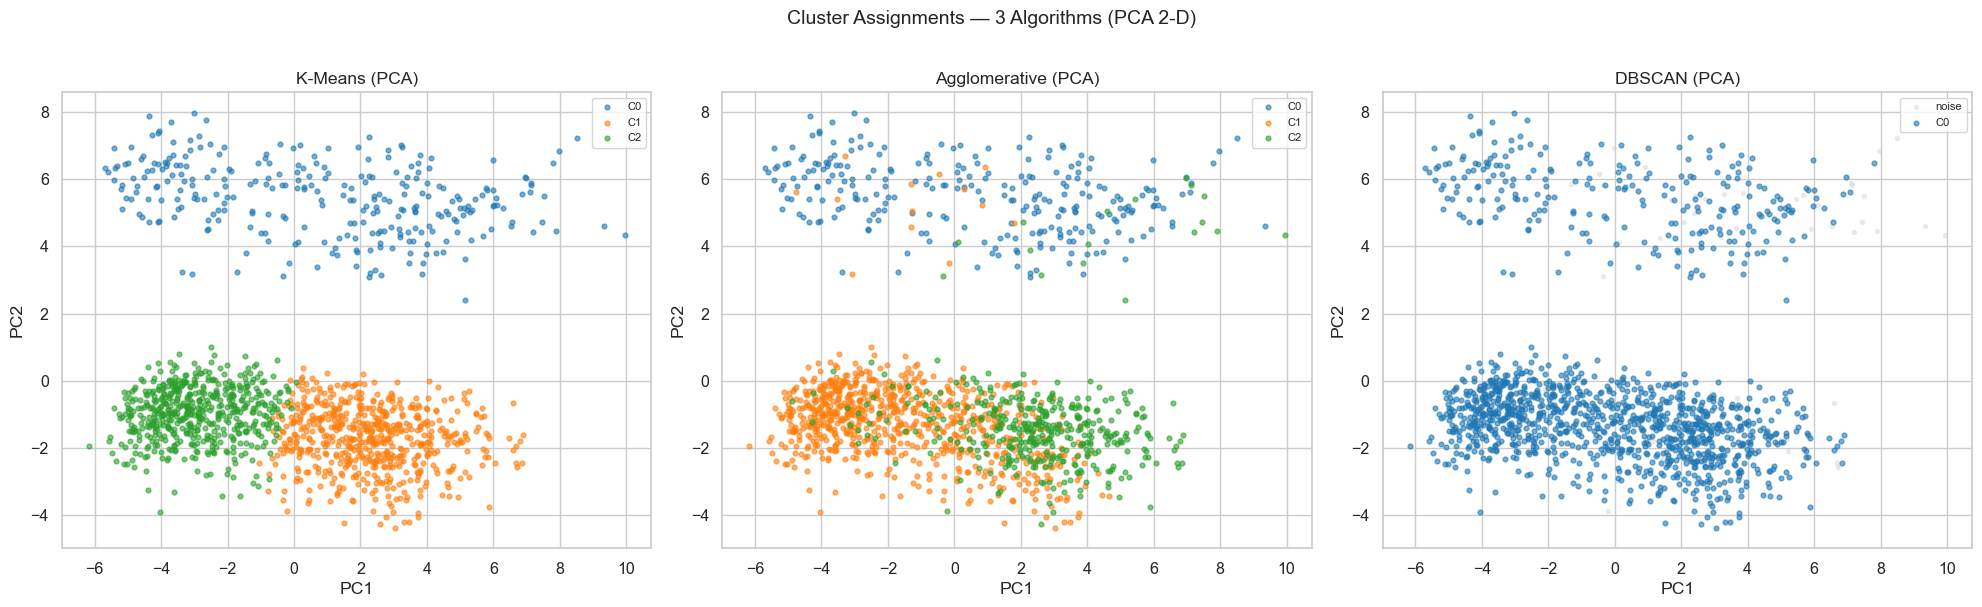

In [23]:
palette = sns.color_palette("tab10", 10)

def plot_clusters(X_2d, labels, title, ax):
    for cl in sorted(set(labels)):
        if cl == -1:
            ax.scatter(X_2d[labels == cl, 0], X_2d[labels == cl, 1],
                       s=8, c="lightgray", alpha=0.4, label="noise")
        else:
            ax.scatter(X_2d[labels == cl, 0], X_2d[labels == cl, 1],
                       s=12, alpha=0.6, label=f"C{cl}",
                       color=palette[cl % len(palette)])
    ax.set_title(title)
    ax.legend(fontsize=8, loc="best")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plot_clusters(pca2d, labels_km, "K-Means (PCA)", axes[0])
plot_clusters(pca2d, labels_agg, "Agglomerative (PCA)", axes[1])
plot_clusters(pca2d, labels_db, "DBSCAN (PCA)", axes[2])

for ax in axes:
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

plt.suptitle("Cluster Assignments — 3 Algorithms (PCA 2-D)", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(f"{OUT}/06_cluster_assignments.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.2 K-Means Comparison Across k Values

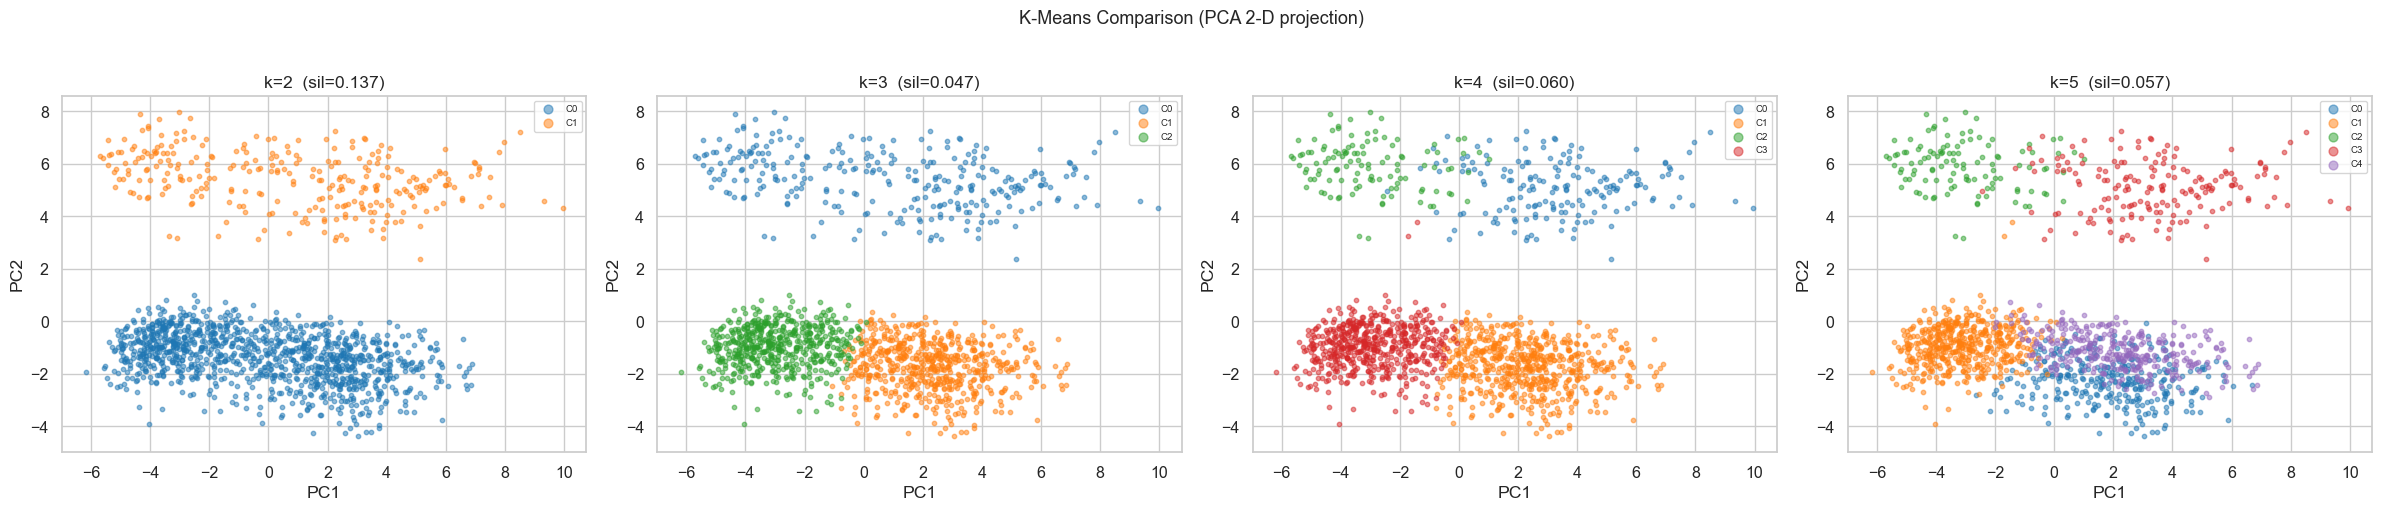

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for ax, k in zip(axes, [2, 3, 4, 5]):
    labs = KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X_pca)
    sil = silhouette_score(X_pca, labs)
    for cl in range(k):
        mask = labs == cl
        ax.scatter(pca2d[mask, 0], pca2d[mask, 1], s=10, alpha=0.5,
                   label=f"C{cl}", color=palette[cl % len(palette)])
    ax.set_title(f"k={k}  (sil={sil:.3f})")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.legend(fontsize=7, markerscale=2)

plt.suptitle("K-Means Comparison (PCA 2-D projection)", fontsize=13, y=1.02)
plt.tight_layout()
fig.savefig(f"{OUT}/07_kmeans_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.3 Hierarchical Dendrogram

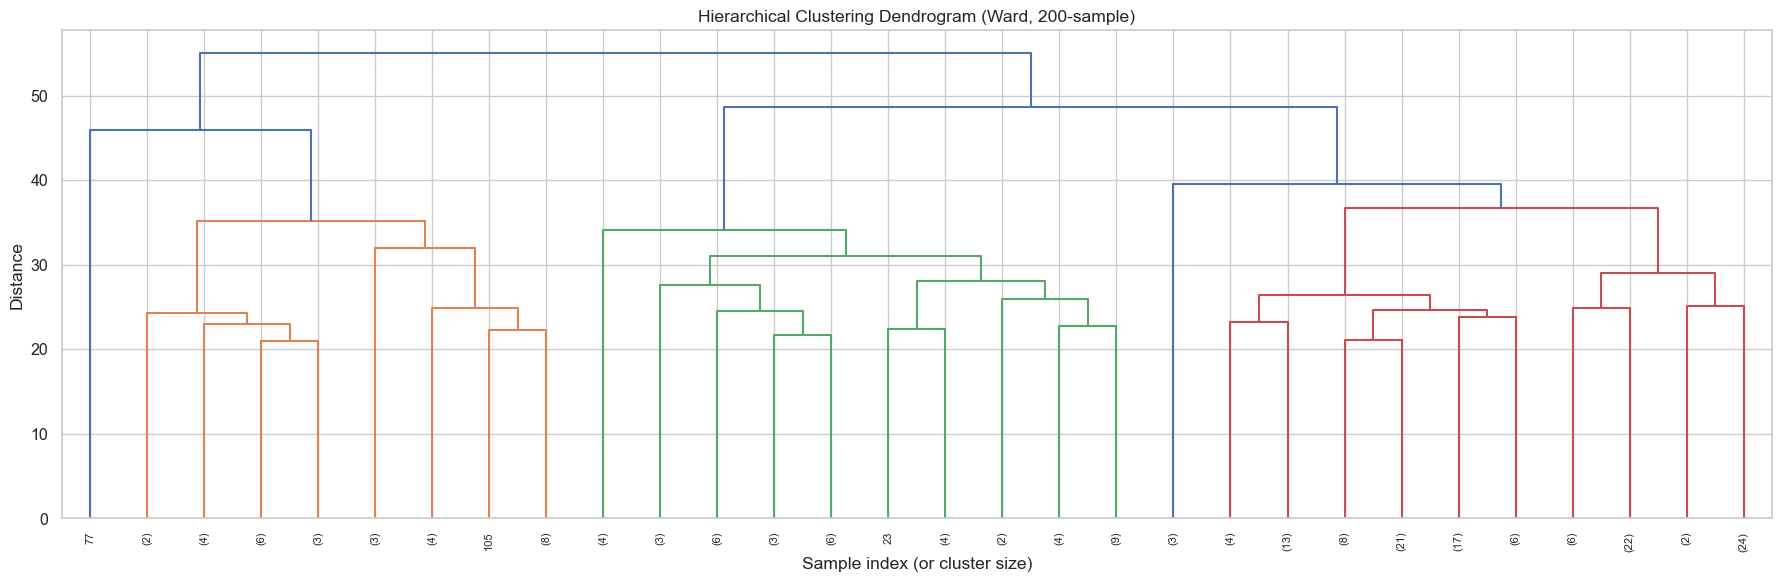

In [25]:
# Hierarchical clustering dendrogram (Ward linkage on PCA-reduced data)
# Use a sample if dataset is large for readability
n_sample = min(200, X_pca.shape[0])
rng = np.random.RandomState(42)
idx = rng.choice(X_pca.shape[0], n_sample, replace=False)
X_dendro = X_pca[idx]

Z = linkage(X_dendro, method="ward")

fig, ax = plt.subplots(figsize=(18, 6))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90,
           leaf_font_size=8, ax=ax, color_threshold=0.7 * max(Z[:, 2]))
ax.set_title("Hierarchical Clustering Dendrogram (Ward, 200-sample)")
ax.set_xlabel("Sample index (or cluster size)")
ax.set_ylabel("Distance")

plt.tight_layout()
fig.savefig(f"{OUT}/08_dendrogram.png", dpi=150)
plt.show()

---
## 8. Cluster Profiling & Interpretation

Using the K-Means labels with k=3, we profile each cluster against the original (human-readable) survey responses.

In [26]:
prof = df_for_profiling.copy()
prof["cluster"] = labels_km

profile_cols = [
    "age", "gender", "self_employed", "tech_company",
    "mh_benefits", "current_mh_disorder", "past_mh_disorder",
    "sought_treatment", "productivity_affected", "family_history",
    "remote_work", "professionally_diagnosed",
    "comfort_mh_coworkers", "comfort_mh_supervisor",
    "employer_mh_serious", "mh_hurts_career",
]
profile_cols = [c for c in profile_cols if c in prof.columns]

for cl in range(PRIMARY_K):
    subset = prof[prof["cluster"] == cl]
    print(f"\n{'='*60}")
    print(f"Cluster {cl}  (n={len(subset)}, {len(subset)/len(prof):.1%})")
    print(f"{'='*60}")
    for col in profile_cols:
        if prof[col].dtype in ["int64", "float64"]:
            print(f"  {col:>35s}: mean={subset[col].mean():.2f}")
        else:
            top = subset[col].value_counts(normalize=True).head(3)
            vals = ", ".join(f"{v}={p:.0%}" for v, p in top.items())
            print(f"  {col:>35s}: {vals}")


Cluster 0  (n=287, 20.0%)
                                  age: mean=36.80
                               gender: Male=73%, Female=24%, Non-binary=3%
                        self_employed: mean=1.00
                         tech_company: mean=nan
                          mh_benefits: 
                  current_mh_disorder: Yes=43%, No=31%, Maybe=25%
                     past_mh_disorder: Yes=53%, No=25%, Maybe=22%
                     sought_treatment: mean=0.63
                productivity_affected: Yes=71%, Unsure=13%, Not applicable to me=11%
                       family_history: Yes=45%, No=34%, I don't know=21%
                          remote_work: Sometimes=51%, Always=44%, Never=5%
             professionally_diagnosed: Yes=52%, No=48%
                 comfort_mh_coworkers: 
                comfort_mh_supervisor: 
                  employer_mh_serious: 
                      mh_hurts_career: Yes, I think it would=40%, Maybe=40%, No, I don't think it would=9%

Cluster 1  (n=

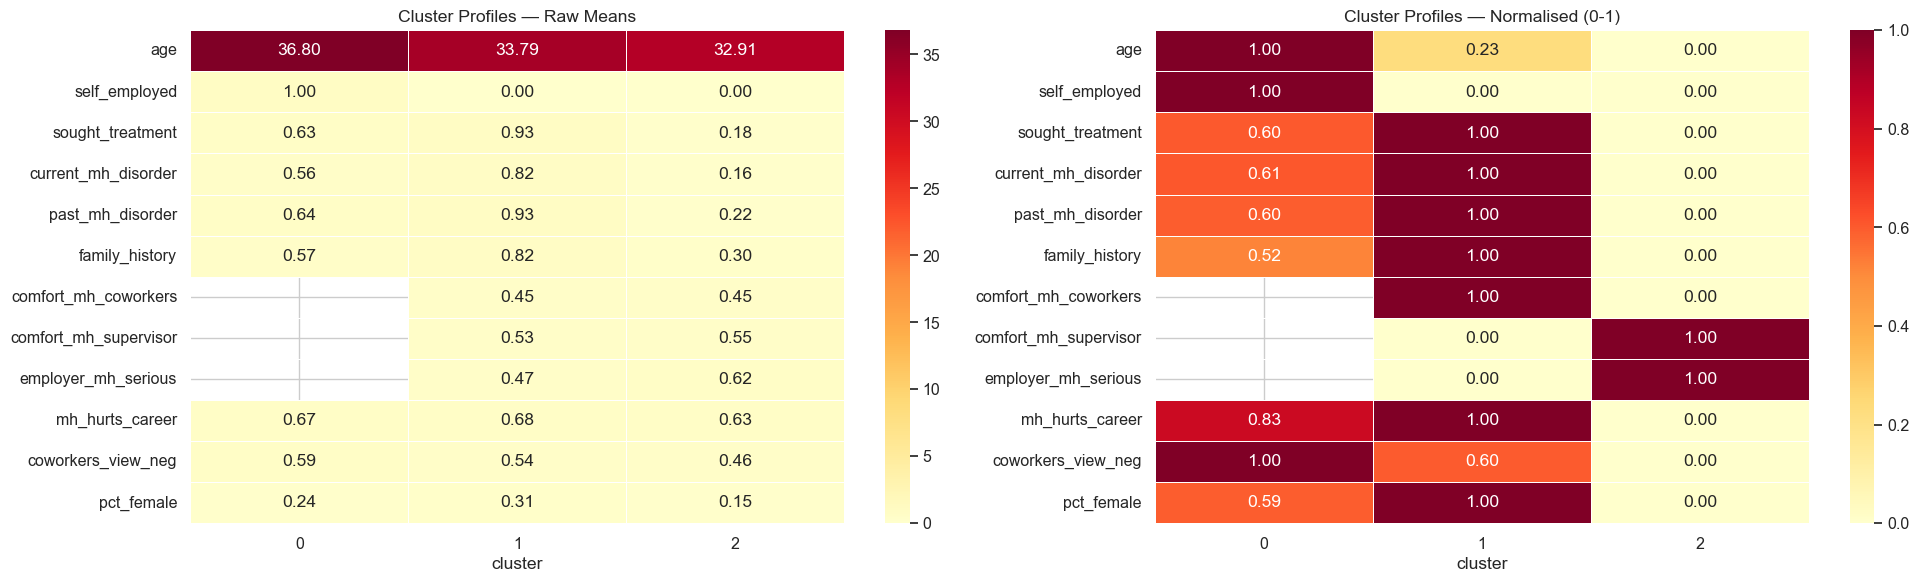

In [27]:
# Heatmap: encode key categoricals to numeric for visualisation
heatmap_df = prof.copy()

yes_maybe_cols = ["current_mh_disorder", "past_mh_disorder", "family_history",
                  "comfort_mh_coworkers", "comfort_mh_supervisor",
                  "employer_mh_serious", "observed_neg_consequences"]
for col in yes_maybe_cols:
    if col in heatmap_df.columns:
        heatmap_df[col] = heatmap_df[col].map({"Yes": 1.0, "Maybe": 0.5, "No": 0.0})

for col in ["mh_hurts_career", "coworkers_view_neg"]:
    if col in heatmap_df.columns:
        heatmap_df[col] = heatmap_df[col].map({
            "Yes, I think it would": 1.0, "Yes, I think they would": 1.0,
            "Maybe": 0.5,
            "No, I don't think it would": 0.0, "No, I don't think they would": 0.0})

if "gender" in heatmap_df.columns:
    heatmap_df["pct_female"] = (heatmap_df["gender"] == "Female").astype(float)

heatmap_cols = [
    "age", "self_employed", "sought_treatment", "professionally_diagnosed",
    "current_mh_disorder", "past_mh_disorder", "family_history",
    "comfort_mh_coworkers", "comfort_mh_supervisor",
    "employer_mh_serious", "mh_hurts_career", "coworkers_view_neg", "pct_female",
]
heatmap_cols = [c for c in heatmap_cols if c in heatmap_df.columns
                and heatmap_df[c].dtype in ("int64", "float64")]

profile_data = heatmap_df.groupby("cluster")[heatmap_cols].mean()

# Normalise to 0-1 for better contrast
profile_norm = profile_data.copy()
for col in heatmap_cols:
    cmin, cmax = profile_data[col].min(), profile_data[col].max()
    if cmax > cmin:
        profile_norm[col] = (profile_data[col] - cmin) / (cmax - cmin)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(profile_data.T, annot=True, fmt=".2f", cmap="YlOrRd",
            ax=axes[0], linewidths=0.5)
axes[0].set_title("Cluster Profiles — Raw Means")

sns.heatmap(profile_norm.T, annot=True, fmt=".2f", cmap="YlOrRd",
            ax=axes[1], linewidths=0.5)
axes[1].set_title("Cluster Profiles — Normalised (0-1)")

plt.tight_layout()
fig.savefig(f"{OUT}/09_cluster_profiles.png", dpi=150)
plt.show()

### Cluster Summary

| | Cluster 0 (~20%) | Cluster 1 (~42%) | Cluster 2 (~38%) |
|---|---|---|---|
| **Label** | Self-employed | Employed, high MH burden | Employed, low MH burden |
| **Current MH disorder** | 43% Yes | 72% Yes | 3% Yes |
| **Sought treatment** | 63% | 93% | 18% |
| **Professionally diagnosed** | 52% | 90% | 5% |
| **Family history** | 45% | 68% | 24% |
| **Gender** | 73% male | 64% male | 85% male |
| **Career fear** | 40% Yes | 40% Yes | 37% Yes |

**Key takeaways:**
- **Cluster 1** is a high-priority group: employed tech workers with diagnosed MH conditions who are actively seeking treatment but still fear career consequences.
- **Cluster 2** is the low-MH-burden majority (mostly male, rarely diagnosed, not seeking treatment) but ~37% still fear career impact from MH issues, suggesting stigma is pervasive even among the unaffected.
- **Cluster 0** (self-employed) is structurally distinct due to survey routing. they lack employer-related data and have moderate MH prevalence.

---
## 9. Export

In [28]:
df_out = df_feat.copy()
df_out["cluster_kmeans"] = labels_km
df_out["cluster_agglo"] = labels_agg
df_out["cluster_dbscan"] = labels_db
df_out["pca_1"] = pca2d[:, 0]
df_out["pca_2"] = pca2d[:, 1]

df_out.to_csv(f"{OUT}/processed_with_clusters.csv", index=False)
print(f"Saved: {df_out.shape[0]} rows x {df_out.shape[1]} columns → {OUT}/processed_with_clusters.csv")

Saved: 1433 rows x 155 columns → outputs/processed_with_clusters.csv
